# Neural Music Genre Classification - MLDL - A.Y. 2020/21 - Politecnico di Torino

# 1.Loading the dataset and pre-processing

In [1]:
from google.colab import drive
import torch
drive.mount('/content/drive/')
 
if (torch.cuda.is_available()):
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
 
print(f'Device is set to {DEVICE}')

Mounted at /content/drive/
Device is set to cuda


In [2]:
import os
from sklearn.metrics import f1_score
import torchvision
from torchvision import models, datasets
import math

from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import librosa.display
try:
    import torchaudio
except:
    ! pip install torchaudio
    import torchaudio
import librosa
from torchaudio import datasets
import torchaudio.functional as FA
import torchaudio.transforms as TA
from sklearn.metrics import confusion_matrix
import itertools
import gzip, pickle
import copy
import sys
import time
from datetime import datetime
from sklearn.metrics import multilabel_confusion_matrix
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
seed = 2045 # The singularity is near!
def manual_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    from torch.backends import cudnn
    cudnn.deterministic = True #type: ignore
    cudnn.benchmark = False # type: ignore

hparams = {'batch_size': 16}

path = './drive/MyDrive/music_classification/Data'
data_dir = path
print(os.listdir(data_dir))
classes = os.listdir(data_dir+'/images_original')
print(classes)

     |████████████████████████████████| 1.9MB 5.1MB/s 
['features_30_sec.csv', 'features_3_sec.csv', 'images_original', 'genres_original', 'images_three_sec', 'images_one_sec', 'images_ten_sec', 'images_thirty_sec', 'Original_Songs', 'test_songs_three_sec', 'test_songs_thirty_sec', 'test_songs_ten_sec', 'test_songs_one_sec', 'Songs']
['reggae', 'classical', 'rock', 'disco', 'jazz', 'metal', 'blues', 'pop', 'country', 'hiphop']


## MELs

In [3]:
def sizing_waveform(waveform, min_len, chunks):
  incr_step = int(min_len/chunks)
  splitted = torch.split(waveform, incr_step, dim=1)
  all_chunks = []

  for i in range(chunks):
    all_chunks.append(splitted[i])
  
  return all_chunks

In [4]:
# counter = 0
# maxLen = -1
# minLen = 100000000000
# for i in dataset_dl:
#     waveform, sample_rate, label = i
#     l = int(waveform.shape[1])
#     if l<minLen:
#         minLen = l
#     if l>maxLen:
#         maxLen = l
#     counter += 1

1000
660000
675808

In [5]:
# print(counter)
# print(minLen)
# print(maxLen)

In [6]:
# n_fft=256
# sample_rate=22500
# mel_spectogram = TA.MelSpectrogram(sample_rate = sample_rate, n_mels=192)
# y, sr = librosa.load(librosa.util.example_audio_file()) # your file
# S = librosa.feature.melspectrogram(waveforms[j].numpy()[0], n_mels=192, fmax=8000, hop_length=200)
# librosa.display.specshow(librosa.power_to_db(S, ref=np.max), fmax=8000)
# print(mel_spectogram)
#plt.savefig('mel.png')

In [7]:
# dataset_dl = datasets.GTZAN('./drive/MyDrive/music_classification/GTZAN', download=False)
# save_path = './drive/MyDrive/music_classification/Data/images_thirty_sec'
# counter_dict = dict(zip(classes, [0]*len(classes)))
# chunks = 1
# MIN_LEN = 660000

In [8]:
done = []

2007, 201, 67

In [9]:
# for i in dataset_dl:
#     waveform, sample_rate, label = i
#     waveforms = sizing_waveform(waveform, MIN_LEN, chunks)
#     if label in ['country']:
#         if counter_dict[label] >= 62:
#             for j in range(chunks):
#                 S = librosa.feature.melspectrogram(waveforms[j].numpy()[0], n_mels=192, fmax=8000, hop_length=67)
#                 librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
#                 #print(S)
#                 #print(S.shape)
#                 plt.savefig(save_path+f'/{label}/'+f'{label}'+format(counter_dict[label], '05d')+f'_'+format(j, '03d')+'.png')
#                 #break
#         counter_dict[label] += 1
#         #break

In [10]:
def create_melSpectogram(waveforms, sample_rate):
  melspecs= []

  for wave in waveforms:
    MS = mel_spectogram(wave)
    melspecs.append(MS[0])
 
  return melspecs


In [11]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  cmap = plt.get_cmap('inferno')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect, cmap=cmap)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)
  return im

In [12]:
class CustomCrop(object):
    """Custom Crop"""
    def __call__(self, image):
        return image[:,54:-42,54:-42]

In [13]:
import torchvision.transforms as transforms
trans_norm = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.0,0.0,0.0), (1,1,1)),
                            #transforms.Resize(inp_shape)
                            #transforms.CenterCrop(256)
                            ])
trans = transforms.Compose([transforms.ToTensor(),
                            #CustomCrop()
                            #transforms.Resize(inp_shape)
                            #transforms.CenterCrop(256)
                            ])

In [16]:
dataset = ImageFolder(data_dir+'/images_one_sec',transform=trans)

In [17]:
# img, label = dataset[0]
# print(img.shape, label)
# fig, ax = plt.subplots(figsize=(10,15))
# img = torch.transpose(img,0,2)
# ax.axis('off')
# ax.imshow(torch.transpose(img,0,1))

In [18]:
print(len(dataset))

30000


# 2. Train-Test Split

In [19]:
train_size = int(np.ceil(len(dataset)*0.8))
val_size = int(np.ceil(len(dataset)*0.1))
test_size = len(dataset) - train_size - val_size
print(train_size, val_size, test_size)
manual_seed(2045)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths = [train_size, val_size, test_size])
# indices = np.random.permutation(len(dataset))
# train_idx, val_idx, test_idx = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

num_workers = 2
pin_memory = True
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=hparams['batch_size'], num_workers=num_workers, pin_memory=pin_memory)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=hparams['batch_size'], num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=hparams['batch_size'], num_workers=num_workers, pin_memory=pin_memory)

24000 3000 3000


# 3. Visualization

In [20]:
def get_number_distribution(loader, classes):
  total_category_count = {classes[i] : 0 for i in range(len(classes))}
  for _, labels in loader:
    for label in labels:
        total_category_count[classes[label]] += 1
  cat_count = []
  for category in classes:
    print('%s : %d' % (category, total_category_count[category]))
    cat_count.append((category, total_category_count[category]))
  cat_count.sort(key=lambda x:x[1])
  cat_count.reverse()
  return cat_count

In [21]:
# print('Train Set Number Ditribution:')
# train_cat_count = get_number_distribution(train_loader, classes)

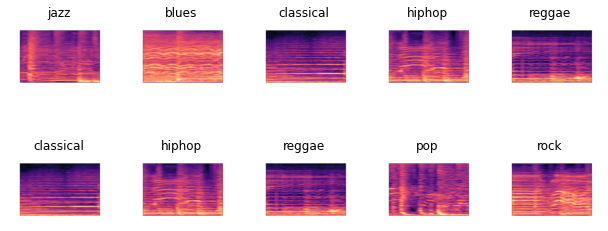

In [22]:
def imshow(img_array, labels, classes):
    figure, axs = plt.subplots(2, 5) 
    for i in range(2):
      for j in range(5):
        imgTmp = torch.transpose(img_array[i*2 + j],0,2)
        axs[i][j].imshow(torch.transpose(imgTmp, 0, 1))
        axs[i][j].set_title(classes[labels[i*2 + j]])
        axs[i][j].axis('off')
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
    plt.show()

data_iter = iter(train_loader)
data_iter.next()
images, labels = data_iter.next()
distinct_labels = []
distinct_images = []
distinct_classes = []
for i in range(len(labels)):
  if classes[labels[i]] not in distinct_classes:
    distinct_labels.append(labels[i])
    distinct_images.append(images[i])
    distinct_classes.append(classes[labels[i]])
imshow(distinct_images[0:10], distinct_labels[0:10], classes)

# 4. Model

In [23]:
# from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
# resnet_net = torchvision.models.resnet152(pretrained=True)
# modules = list(resnet_net.children())[:-1]
# backbone = nn.Sequential(*modules)
# ct = 0
# for child in backbone.children():
#     ct += 1
#     if ct < 7:
#         for param in child.parameters():
#             param.requires_grad = False
# # backbone.out_channels = 512
# #backbone = resnet_fpn_backbone('resnet18', pretrained=True, trainable_layers=5)

In [24]:
# #backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))

# backbone.to(DEVICE)
# summary(backbone, (hparams['c'], hparams['h'], hparams['w']), batch_size=hparams['batch_size'])

In [26]:
class CRNN(nn.Module):
    def __init__(self, class_num, c, h, w, k, filters, poolings, dropout_rate, gru_dropout=0.3, gru_units=32):
        super(CRNN, self).__init__()
        input_shape = (c, h, w)
        #print(input_shape)
        # CNN
        self.backbone = torchvision.models.resnet18(pretrained=True)
        modules = list(self.backbone.children())[:-1]
        self.backbone = nn.Sequential(*modules)
        ct = 0
        for child in self.backbone.children():
            ct += 1
            if ct < 7:
                for param in child.parameters():
                    param.requires_grad = False
        # self.bn0 = nn.BatchNorm2d(num_features=c)
        # self.pad1 = nn.ZeroPad2d((int(k/2), int(k/2), int(k/2), int(k/2)))
        # self.conv1 = nn.Conv2d(c, filters[0], kernel_size=k, stride=1)
        # self.act1 = nn.ELU()
        # self.bn1 = nn.BatchNorm2d(num_features=filters[0])
        # self.maxPool1 = nn.MaxPool2d(kernel_size=poolings[0], stride=poolings[0])
        # self.drouput1 = nn.Dropout2d(dropout_rate)

        # self.pad2 = nn.ZeroPad2d((int(k/2), int(k/2), int(k/2), int(k/2)))
        # self.conv2 = nn.Conv2d(filters[0], filters[1], kernel_size=k)
        # self.act2 = nn.ELU()
        # self.bn2 = nn.BatchNorm2d(num_features=filters[1])
        # self.maxPool2 = nn.MaxPool2d(kernel_size=poolings[1], stride=poolings[1])
        # self.drouput2 = nn.Dropout2d(dropout_rate)

        # self.pad3 = nn.ZeroPad2d((int(k/2), int(k/2), int(k/2), int(k/2)))
        # self.conv3 = nn.Conv2d(filters[1], filters[2], kernel_size=k)
        # self.act3 = nn.ELU()
        # self.bn3 = nn.BatchNorm2d(num_features=filters[2])
        # self.maxPool3 = nn.MaxPool2d(kernel_size=poolings[2], stride=poolings[2])
        # self.drouput3 = nn.Dropout2d(dropout_rate)

        # self.pad4 = nn.ZeroPad2d((int(k/2), int(k/2), int(k/2), int(k/2)))
        # self.conv4 = nn.Conv2d(filters[2], filters[3], kernel_size=k)
        # self.act4 = nn.ELU()
        # self.bn4 = nn.BatchNorm2d(num_features=filters[3])
        # self.maxPool4 = nn.MaxPool2d(kernel_size=poolings[3],stride=poolings[3])
        # self.drouput4 = nn.Dropout2d(dropout_rate)

        # self.pad5 = nn.ZeroPad2d((int(k/2), int(k/2), int(k/2), int(k/2)))
        # self.conv5 = nn.Conv2d(filters[3], filters[4], kernel_size=k)
        # self.act5 = nn.ELU()
        # self.bn5 = nn.BatchNorm2d(num_features=filters[4])
        # self.maxPool5 = nn.MaxPool2d(kernel_size=poolings[4],stride=poolings[4])
        # self.drouput5 = nn.Dropout2d(dropout_rate)
        # Output is (m, chan, freq, time) -> Needs to be reshaped for feeding to GRU units
        # We will handle the reshape in the forward method

        # RNN
        self.gru = nn.GRU(input_size=512, hidden_size=32, batch_first=True, num_layers=3, dropout=gru_dropout)
        #self.gru2 = nn.GRU(input_size=32, hidden_size=32, batch_first=True, dropout=gru_dropout)

        # Dense and softmax
        self.dense1 = nn.Linear(32, class_num)
        self.softm = nn.Softmax(dim=-1)
        
    def forward(self, x):
        # CNN forward
        # x = self.bn0(x)
        # x = self.pad1(x)
        # x = self.conv1(x)
        # x = self.act1(x)
        # x = self.bn1(x)
        # x = self.maxPool1(x)
        # x = self.drouput1(x)

        # x = self.pad2(x)
        # x = self.conv2(x)
        # x = self.act2(x)
        # x = self.bn2(x)
        # x = self.maxPool2(x)
        # x = self.drouput2(x)

        # x = self.pad3(x)
        # x = self.conv3(x)
        # x = self.act3(x)
        # x = self.bn3(x)
        # x = self.maxPool3(x)
        # x = self.drouput3(x)

        # x = self.pad4(x)
        # x = self.conv4(x)
        # x = self.act4(x)
        # x = self.bn4(x)
        # x = self.maxPool4(x)
        # x = self.drouput4(x)

        # x = self.pad5(x)
        # x = self.conv5(x)
        # x = self.act5(x)
        # x = self.bn5(x)
        # x = self.maxPool5(x)
        # x = self.drouput5(x)
        x = self.backbone(x)

        # Reshape
        x = x.permute(0,3,2,1)
        x = torch.reshape(x, (int(x.shape[0]), int(x.shape[1]), int(x.shape[2]*x.shape[3])))
        # RNN forward
        x = self.gru(x)[1][0]
        #x = self.gru2(x)[1][0]
        # Dense and softmax forward
        x = self.dense1(x)
        x = self.softm(x)
        return x

In [27]:
### Hyperparameters
inp_shape = (288, 432)
c=3                 # Channel
h = inp_shape[0]    # Frequency
w = inp_shape[1]    # Time
k=3
filters = [64, 128, 256, 512, 512]
poolings = [(2, 2), (2, 2), (2, 2), (4, 1), (4, 1)]
dropout_rate = 0.1      # 0.2
gru_dropout_rate = 0.3
batch_size = 16
gru_units=32
lr = 0.0001
n_classes = 10
patience = 10
epochs = 1
hparams = {'batch_size': batch_size, 'c': c, 'h':h, 'w':w, 'k':k, 'filters': filters,\
               'poolings': poolings, 'dropout_rate':dropout_rate,\
            'gru_units': gru_units, 'lr': lr, 'dropout_gru':gru_dropout_rate, 'epochs':epochs, 'patience':patience}

In [28]:
from torchsummary import summary
model = CRNN(len(classes), hparams['c'], hparams['h'], hparams['w'], hparams['k'], hparams['filters'],\
                      hparams['poolings'], hparams['dropout_rate'], gru_units=hparams['gru_units'], gru_dropout = hparams['dropout_gru'])
model.to(DEVICE)
summary(model, (hparams['c'], hparams['h'], hparams['w']), batch_size=hparams['batch_size'])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 144, 216]           9,408
       BatchNorm2d-2         [16, 64, 144, 216]             128
              ReLU-3         [16, 64, 144, 216]               0
         MaxPool2d-4          [16, 64, 72, 108]               0
            Conv2d-5          [16, 64, 72, 108]          36,864
       BatchNorm2d-6          [16, 64, 72, 108]             128
              ReLU-7          [16, 64, 72, 108]               0
            Conv2d-8          [16, 64, 72, 108]          36,864
       BatchNorm2d-9          [16, 64, 72, 108]             128
             ReLU-10          [16, 64, 72, 108]               0
       BasicBlock-11          [16, 64, 72, 108]               0
           Conv2d-12          [16, 64, 72, 108]          36,864
      BatchNorm2d-13          [16, 64, 72, 108]             128
             ReLU-14          [16, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# 5. Training

In [29]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            #print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('Early stopping activated!')
                self.early_stop = True

In [30]:
def fit(model, train_loader, train_len, optimizer, criterion):
    model.train()
    batch_size = train_loader.batch_size
    n_batches = math.ceil(train_len/batch_size)
    #print('Batch Size:', batch_size,'Number of Batches:', n_batches)
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    #prog_bar = tqdm(enumerate(train_loader), total=int(train_len/batch_size))
    for i, data in enumerate(train_loader):
        counter += 1
        data, target = data[0].to(DEVICE), data[1].to(DEVICE)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [31]:
def validate(model, val_loader, val_len, criterion):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    batch_size = val_len
    #prog_bar = tqdm(enumerate(val_loader), total=int(val_len/batch_size))
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            counter += 1
            data, target = data[0].to(DEVICE), data[1].to(DEVICE)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [34]:
def train(hparams, train_loader, val_loader, train_len, val_len, **kwargs):
    manual_seed(2045)
    model = CRNN(len(classes), hparams['c'], hparams['h'], hparams['w'], hparams['k'], hparams['filters'],\
                    hparams['poolings'], hparams['dropout_rate'], gru_units=hparams['gru_units'])
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])
    try:
        path = kwargs['path']
        stream = gzip.open(path, "rb")
        checkpoint = pickle.load(stream)
        stream.close()
        train_loss = checkpoint['train_loss']
        train_accuracy = checkpoint['train_accuracy']
        val_loss = checkpoint['val_loss']
        val_accuracy = checkpoint['val_accuracy']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_load = checkpoint['epoch']
        print(f'Checkpoint found! Training will resume from epoch {epoch_load+1}')
        print('Last epoch results: ')
        print(f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}")
        print(f'Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_accuracy[-1]:.2f}')
        if 'lr_scheduler' in kwargs.keys() and 'scheduler_state_dict' in checkpoint.keys():
            if kwargs['lr_scheduler'] == True:
                print('Learning rate sceduler is active.\n')
                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, last_epoch=-1, verbose=True)
                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    except:
        print('No checkpoints found! Training will start from the beginning.\n')
        train_loss, train_accuracy = [], []
        val_loss, val_accuracy = [], []
        epoch_load = 0
        scheduler = None
        es = False
        if 'lr_scheduler' in kwargs.keys():
            if kwargs['lr_scheduler'] == True:
                print('Learning rate sceduler is active.\n')
                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, last_epoch=-1, verbose=True)

    es = False
    if 'early_stopping' in kwargs.keys():
        print('Early stopping is active.')
        print()
        es = True
        min_val_loss = np.inf
        patience = 30
        epochs_no_improve = 0
        best_model = None

    criterion = nn.CrossEntropyLoss()

    start = time.time()
    for epoch in range(hparams['epochs']-epoch_load):
        print(f"Epoch {epoch+epoch_load+1} of {hparams['epochs']}")
        train_epoch_loss, train_epoch_accuracy = fit(
            model, train_loader, train_len, optimizer, criterion
        )
        val_epoch_loss, val_epoch_accuracy = validate(
            model, val_loader, val_len, criterion
        )
        if scheduler:
            scheduler.step()
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        if es:
            if val_epoch_loss < min_val_loss:
                #Saving the model
                min_val_loss = val_epoch_loss
                best_model = copy.deepcopy(model.state_dict())
                #print('Min loss %0.2f' % min_loss)
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            # Check early stopping condition
            if epochs_no_improve == patience:
                print(f'Early stopping after {epoch+epoch_load+1} epochs!')
                model.load_state_dict(best_model)
                break
                
        print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
        print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
        checkpoint_to_save = {'model_state_dict': model.state_dict(),                                                 
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch+epoch_load,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy
                }
        if scheduler:
            checkpoint_to_save['scheduler_state_dict'] = scheduler.state_dict()
        stream = gzip.open('/content/drive/MyDrive/music_classification/checkpoint_one_sec_resnet18.pt', "wb")
        pickle.dump(checkpoint_to_save, stream)
        stream.close()
    end = time.time()

    print(f"Training time: {(end-start)/60:.3f} minutes")
    return model, train_loss, train_accuracy, val_loss, val_accuracy

In [35]:
hparams['epochs'] = 1000
hparams['lr'] = 0.0001

In [36]:
path='/content/drive/MyDrive/music_classification/checkpoint_one_sec_resnet18.pt'

In [ ]:
model, train_loss, train_accuracy, val_loss, val_accuracy = train(hparams, train_loader, val_loader, train_size, val_size,\
                                                                  lr_scheduler=False,\
                                                                  early_stopping=True,\
                                                                  path='/content/drive/MyDrive/music_classification/checkpoint_one_sec_resnet18.pt')


No checkpoints found! Training will start from the beginning.

Early stopping is active.

Epoch 1 of 1000
Train Loss: 1.9179, Train Acc: 65.17
Val Loss: 1.7567, Val Acc: 76.63
Epoch 2 of 1000
Train Loss: 1.7100, Train Acc: 79.83
Val Loss: 1.6542, Val Acc: 83.53
Epoch 3 of 1000
Train Loss: 1.6377, Train Acc: 85.03
Val Loss: 1.6238, Val Acc: 85.07
Epoch 4 of 1000
Train Loss: 1.5889, Train Acc: 89.11
Val Loss: 1.5959, Val Acc: 87.93
Epoch 5 of 1000
Train Loss: 1.5597, Train Acc: 91.55
Val Loss: 1.5914, Val Acc: 88.00
Epoch 6 of 1000
Train Loss: 1.5402, Train Acc: 93.24
Val Loss: 1.5803, Val Acc: 89.03
Epoch 7 of 1000
Train Loss: 1.5227, Train Acc: 94.76
Val Loss: 1.5666, Val Acc: 90.03
Epoch 8 of 1000
Train Loss: 1.5122, Train Acc: 95.67
Val Loss: 1.5586, Val Acc: 90.57
Epoch 9 of 1000
Train Loss: 1.5055, Train Acc: 96.26
Val Loss: 1.5512, Val Acc: 91.63
Epoch 10 of 1000
Train Loss: 1.4992, Train Acc: 96.73
Val Loss: 1.5559, Val Acc: 91.23
Epoch 11 of 1000
Train Loss: 1.4929, Train Acc: 9

# 6. Post-processing

In [ ]:
manual_seed(2045)
model = CRNN(len(classes), hparams['c'], hparams['h'], hparams['w'], hparams['k'], hparams['filters'],\
                hparams['poolings'], hparams['dropout_rate'], gru_units=hparams['gru_units'])
model.to(DEVICE)
stream = gzip.open(path, "rb")
checkpoint = pickle.load(stream)
stream.close()
train_loss = checkpoint['train_loss']
train_accuracy = checkpoint['train_accuracy']
val_loss = checkpoint['val_loss']
val_accuracy = checkpoint['val_accuracy']
model.load_state_dict(checkpoint['model_state_dict'])
epoch_load = checkpoint['epoch']
print(f'Model loaded! Model has been trained for {epoch_load+1} epochs.')
print('Last epoch results: ')
print(f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}")
print(f'Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_accuracy[-1]:.2f}')

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)




    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
def detailed_analysis(model, n_classes, class_names, train_loader, val_loader, test_loader, val_accuracy, train_accuracy, val_loss, train_loss):
    model.eval()

    ### Train
    loader = train_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_train = [0.] * n_classes
    y_true = []
    y_pred = []
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
              class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_train[i] = class_corrects[i]/class_totals[i]

    cm_train = confusion_matrix(y_true, y_pred)
    y_true_train = copy.deepcopy(y_true)
    y_pred_train = copy.deepcopy(y_pred)
    

    ### Val
    loader = val_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_val = [0.] * n_classes
    y_true = []
    y_pred = []
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
              class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_val[i] = class_corrects[i]/class_totals[i]
    cm_val = confusion_matrix(y_true, y_pred)
    y_true_val = copy.deepcopy(y_true)
    y_pred_val = copy.deepcopy(y_pred)

    ### Test
    loader = test_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_test = [0.] * n_classes
    y_true = []
    y_pred = []
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
              class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_test[i] = class_corrects[i]/class_totals[i]
    cm_test = confusion_matrix(y_true, y_pred)
    y_true_test = copy.deepcopy(y_true)
    y_pred_test = copy.deepcopy(y_pred)

    fig, axs = plt.subplots(3, figsize=(30,20))
    axs[0].plot(list(range(1,len(train_loss)+1)), train_loss, label='Train Loss')
    axs[0].plot(list(range(1,len(train_loss)+1)), val_loss, label='Val Loss')
    axs[0].set_title('Loss per Epoch')
    axs[0].set_ylabel('Epoch')
    axs[0].set_xlabel('Loss')
    axs[0].legend()

    axs[1].plot(list(range(1,len(train_accuracy)+1)), train_accuracy, label='Train Acc')
    axs[1].plot(list(range(1,len(train_accuracy)+1)), val_accuracy, label='Val Acc')
    axs[1].set_title('Acc per Epoch')
    axs[1].set_ylabel('Epoch')
    axs[1].set_xlabel('Acc')
    axs[1].legend()

    x = np.arange(len(class_names))
    width = 0.3
    trains = axs[2].bar(x - width, class_accs_train, width, label='Train')
    vals = axs[2].bar(x, class_accs_val, width, label = 'Val')
    tests = axs[2].bar(x + width, class_accs_test, width, label = 'Test')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy of Each Class')
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(class_names)
    axs[2].legend()
    plt.show()

    return cm_train, cm_val, cm_test, y_true_train, y_pred_train, y_true_val, y_pred_val, y_true_test, y_pred_test

## Loss and Accuracy Plots

In [ ]:
cm_train, cm_val, cm_test,\
y_true_train, y_pred_train, y_true_val,\
y_pred_val, y_true_test, y_pred_test = detailed_analysis(model, n_classes, classes,\
                                                                      train_loader, val_loader, test_loader,\
                                                                      val_accuracy, train_accuracy, val_loss, train_loss)

## Confusion Matrix

In [ ]:
plot_confusion_matrix(cm_train, classes, title='Confusion matrix for train set', normalize=False)
print()
plot_confusion_matrix(cm_val, classes, title='Confusion matrix for val set', normalize=False)
print()
plot_confusion_matrix(cm_test, classes, title='Confusion matrix for test set', normalize=False)

## F1-Score

In [ ]:
print('Train set F1 score: (Micro)')
f1_score(y_true_train, y_pred_train, average='micro')

In [ ]:
print('Val set F1 score: (Micro)')
f1_score(y_true_val, y_pred_val, average='micro')

In [ ]:
print('Test set F1 score: (Micro)')
f1_score(y_true_test, y_pred_test, average='micro')

# Appendix A. SVM Baseline

In [ ]:
import pandas as pd
features3 = pd.read_csv('./drive/My Drive/music_classification/Data/features_3_sec.csv')
features30 = pd.read_csv('./drive/My Drive/music_classification/Data/features_30_sec.csv')

In [ ]:
# features3.isnull().sum()

In [ ]:
features3.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [ ]:
labels3 = features3['label']
labels30 = features30['label']
features3 = features3.drop(['label', 'filename', 'length'],axis=1)
features30 = features30.drop(['label', 'filename', 'length'],axis=1)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
msk = np.random.rand(len(features3)) < 0.8
X_train3 = features3[msk]
X_test3 = features3[~msk]
y_train3 = labels3[msk]
y_test3 = labels3[~msk]
clf3 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf3.fit(X_train3, y_train3)
y_pred3 = clf3.predict(X_test3)

msk = np.random.rand(len(features30)) < 0.8
X_train30 = features30[msk]
X_test30 = features30[~msk]
y_train30 = labels30[msk]
y_test30 = labels30[~msk]
clf30 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf30.fit(X_train30, y_train30)
y_pred30 = clf30.predict(X_test30)

In [ ]:
class_labels = list(clf3.classes_)

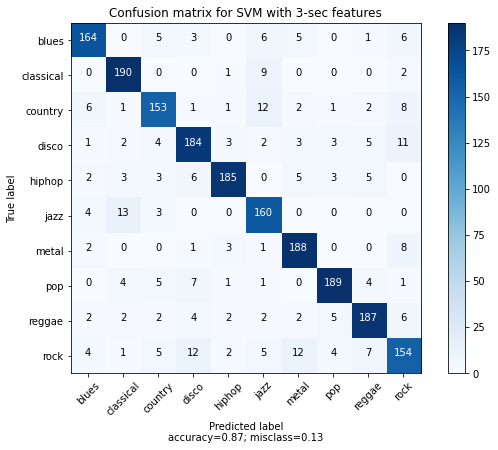

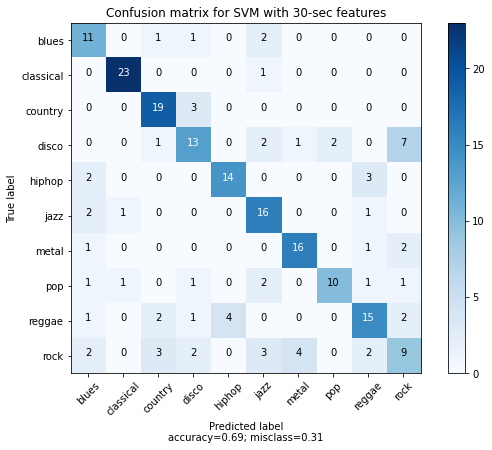

In [ ]:
cm3 = confusion_matrix(y_test3, y_pred3)
plot_confusion_matrix(cm3, class_labels, title='Confusion matrix for SVM with 3-sec features', normalize=False)
print()
cm30 = confusion_matrix(y_test30, y_pred30)
plot_confusion_matrix(cm30, class_labels, title='Confusion matrix for SVM with 30-sec features', normalize=False)

In [ ]:
print('SVM 30-sec F1 score: (Micro)')
f1_score(y_test30, y_pred30, average='micro')

SVM 30-sec F1 score: (Micro)


0.6854460093896714

In [ ]:
print('SVM 3-sec F1 score: (Micro)')
f1_score(y_test3, y_pred3, average='micro')

SVM 3-sec F1 score: (Micro)


0.866600790513834

# Francesco

In [ ]:
def split_indices(n, val_pct, seed):
  #Val set size
  n_val = int(val_pct*n)
  #set random seed
  np.random.seed(seed)
  #Create random perm
  idxs = np.random.permutation(n)
  return idxs[n_val:], idxs[:n_val]

In [ ]:
val_pct = 0.2
rand_seed = 42
train_indices, val_indices = split_indices(len(dataset),val_pct,rand_seed)
print(len(train_indices),len(val_indices))


NameError: ignored

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
batch_size = 16


In [ ]:
train_sampler =SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,batch_size,sampler=train_sampler)

In [ ]:
valid_sampler =SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,batch_size,sampler=valid_sampler)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
for images, labels in train_dl:
  print('images.shape:',images.shape) #from image
  
  
  break

In [ ]:
from torchsummary import summary
#model=CRNN()
#summary(model.cnn,(3, 288, 432),batch_size=16)

In [ ]:
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN,self).__init__()

        self.cnn = nn.Sequential(
            nn.BatchNorm2d(num_features=3),

            nn.Conv2d(3,64,kernel_size=3, padding=1,stride=1),
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(64,128,kernel_size=3, padding=1,stride=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(4,2)),
            nn.Dropout2d(0.1),

            nn.Conv2d(128,128,kernel_size=3, padding=1,stride=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(4,2)),
            nn.Dropout2d(0.1),

            nn.Conv2d(128,128,kernel_size=3, padding=1,stride=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(4,2)),
            nn.Dropout2d(0.1),
            
        )

        self.rnn = nn.Sequential(
            nn.GRU(input_size=6912,hidden_size=32,num_layers=2),
            nn.Dropout2d(0.3),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            
            nn.Linear(in_features=32,out_features=10),
            nn.Softmax2d()
        )

        return
        

    def forward(self, data):

        cnn_output     = self.cnn(data)
        print(cnn_output.size())
        #cnn_output     = cnn_output.squeeze(2)
        #print(cnn_output.size())
        #permute_output = cnn_output.permute(1,0,2)
        rnn_output     = self.rnn(cnn_output)
        print(rnn_output.size())
        output         = self.classifier(rnn_output)
        return output

    


    
    











# Confusion Mat

In [ ]:
#WHERE TO COMPUTE IT? (ONLY TEST SET)

#FIRST OPTION 
#def model_accuracy(model, n_classes, loader):
    #[...] nothing changes here
    #return accuracy, class_accs, output

#train_acc, train_class_accs, _ = model_accuracy(model, n_classes, train_loader)
#test_acc, test_class_accs, test_output = model_accuracy(model,n_classes, test_loader)
#print('Train Set Accuracy: {}%'.format(train_acc))
#print('Test Set Accuracy: {}%'.format(test_acc))
#confusion_matrix(test_loader, output)

#SECOND OPTION: 
#def model_accuracy(model, n_classes, loader, cm):
    #[...] nothing changes here
    #if cm == True : confusion_matrix(loader, outputs)
    #return accuracy, class_accs
  
#train_acc, train_class_accs, _ = model_accuracy(model, n_classes, train_loader, False)
#test_acc, test_class_accs, test_output = model_accuracy(model,n_classes, test_loader, True)
#print('Train Set Accuracy: {}%'.format(train_acc))
#print('Test Set Accuracy: {}%'.format(test_acc))
 

def confusion_matrix(loader, outputs):
        _, predicted = torch.max(outputs.data, 1)
        images, labels = next(iter(loader)) #since only one batch for the test set
  
        stacked= torch.stack(
            (
                labels, 
                predicted 
            ),
            dim=1
        ) #returns a stack in the form [label, prediction]

        cmt = torch.zeros(10, 10, dtype=torch.int32) 

        for p in stacked:
            true, predicted = p.tolist() 
            cmt[true, predicted]= cmt[true, predicted]+1
        
        print(cmt)
        #check for a better plotting function 
